In [ ]:
!pip install kaggle

# Assuming you have your kaggle.json file uploaded to your Colab environment
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset

!unzip coronahack-chest-xraydataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0446-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0447-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0448-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0449-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0450-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0451-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0452-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001-0002.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/IM-0453-0001.jpeg  
  inflating: Coronahack-Chest-XRay-Dataset/Coronahack

In [ ]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.applications.efficientnet import EfficientNetB7, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image


In [ ]:

extracted_data_path = "Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset"
label_info_path = "Chest_xray_Corona_Metadata.csv"

# Check if the file exists at the given path
if os.path.exists(label_info_path):
    df = pd.read_csv(label_info_path)
    df.head()
else:
    print(f"Error: File not found at {label_info_path}")
    print("Please check if the dataset was correctly unzipped.")
    print("The unzipped folder should contain 'Chest_xray_Corona_Metadata.csv'")

In [ ]:
df.isnull().sum()

,0
Unnamed: 0,0
X_ray_image_name,0
Label,0
Dataset_type,0
Label_2_Virus_category,5841
Label_1_Virus_category,1576


In [ ]:
df

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN
...,...,...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,Pnemonia,TEST,NaN,Virus
5906,5929,person1635_virus_2831.jpeg,Pnemonia,TEST,NaN,Virus
5907,5930,person1634_virus_2830.jpeg,Pnemonia,TEST,NaN,Virus
5908,5931,person1633_virus_2829.jpeg,Pnemonia,TEST,NaN,Virus


In [ ]:
path_metadata = '../input/coronahack-chest-xraydataset/Chest_xray_Corona_Metadata.csv'
path_train = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
path_test = 'Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
path_fasttext = '../input/fasttext-common-crawl-bin-model/cc.en.300.bin'
path_test_img = '../input/coronahack-chest-xraydataset/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/kjr-21-e24-g003-l-a.jpg'

In [ ]:
df1 = df.copy()
df1.Label_1_Virus_category.fillna(df1.Label, inplace=True)
df1.Label_2_Virus_category.fillna(df1.Label_1_Virus_category,
                                          inplace=True)
df1.drop(['Label', 'Label_1_Virus_category'], axis=1, inplace=True)
df1.rename(columns={'X_ray_image_name':  'Filename',
                            'Dataset_type': 'Type',
                            'Label_2_Virus_category': 'Class'}, inplace=True)
df1.Class.replace({'Virus': 'viral pneumonia',
                           'bacteria': 'bacterial pneumonia',
                           'Normal': 'normal',
                           'COVID-19': 'covid-19'}, inplace=True)
df1

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal
...,...,...,...,...
5905,5928,person1637_virus_2834.jpeg,TEST,viral pneumonia
5906,5929,person1635_virus_2831.jpeg,TEST,viral pneumonia
5907,5930,person1634_virus_2830.jpeg,TEST,viral pneumonia
5908,5931,person1633_virus_2829.jpeg,TEST,viral pneumonia


In [ ]:
df1.shape

(5910, 4)

In [ ]:
df1['Class'].value_counts()

,count
Class,
bacterial pneumonia,2772
normal,1576
viral pneumonia,1493
covid-19,58
Streptococcus,5
SARS,4
ARDS,2


In [ ]:
# dataframes (training, validation, testing)
df_train = df1[(df1.Type == 'TRAIN')]
df_test = df1[(df1.Type == 'TEST').reset_index(drop=True)]

# df_zsl = df[(df.Class.isin(class_zsl))].reset_index(drop=True)

In [ ]:
df_train.head()

,Unnamed: 0,Filename,Type,Class
0,0,IM-0128-0001.jpeg,TRAIN,normal
1,1,IM-0127-0001.jpeg,TRAIN,normal
2,2,IM-0125-0001.jpeg,TRAIN,normal
3,3,IM-0122-0001.jpeg,TRAIN,normal
4,4,IM-0119-0001.jpeg,TRAIN,normal


In [ ]:
df_train.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Type','Unnamed: 0'], axis=1, inplace=True)
# df_jsl.drop(['Type','Unnamed: 0'], axis=1, inplace=True)

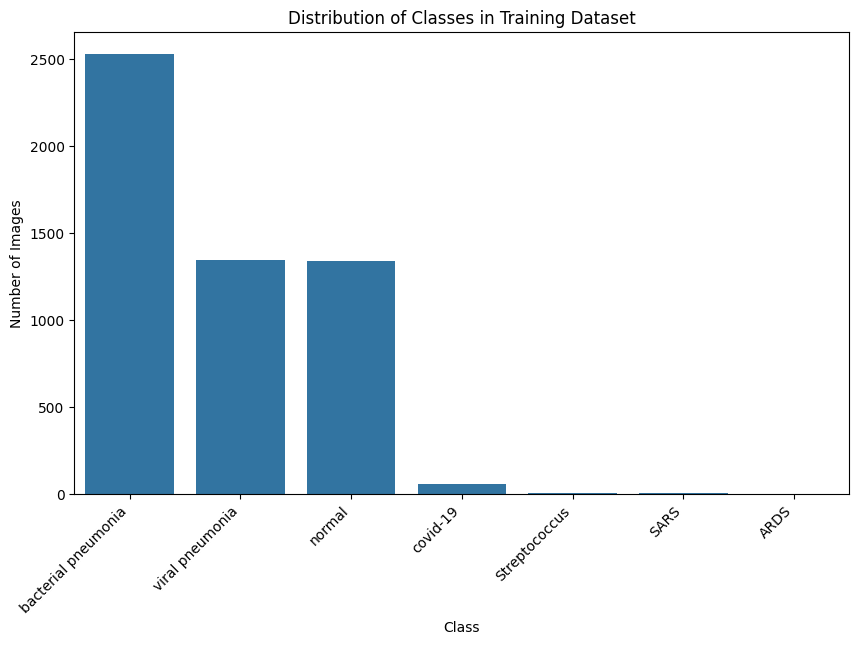

In [ ]:


# Count the occurrences of each class
class_counts = df_train['Class'].value_counts()

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes in Training Dataset')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.show()

In [ ]:
# prompt: select bacterial pneumonia,  viral pneumonia, normal from train dataset

import pandas as pd

# Assuming df_train is already defined from the previous code
selected_classes = ['bacterial pneumonia', 'viral pneumonia', 'normal']
df_train = df_train[df_train['Class'].isin(selected_classes)]

df_train

,Filename,Class
0,IM-0128-0001.jpeg,normal
1,IM-0127-0001.jpeg,normal
2,IM-0125-0001.jpeg,normal
3,IM-0122-0001.jpeg,normal
4,IM-0119-0001.jpeg,normal
...,...,...
5212,person88_virus_167.jpeg,viral pneumonia
5213,person88_virus_166.jpeg,viral pneumonia
5214,person88_virus_165.jpeg,viral pneumonia
5215,person88_virus_164.jpeg,viral pneumonia


In [ ]:
from sklearn.utils import resample

# Target number of samples per class
target_count = 1947  # The smallest class count (you can adjust this value)

# Create separate DataFrames for each class
bacterial_pneumonia = df_train[df_train['Class'] == 'bacterial pneumonia']
normal = df_train[df_train['Class'] == 'normal']
viral_pneumonia = df_train[df_train['Class'] == 'viral pneumonia']

# Downsample bacterial pneumonia
bacterial_pneumonia_downsampled = resample(bacterial_pneumonia,
                                           replace=True,  # Sample without replacement
                                           n_samples=target_count,
                                           random_state=42)

# Downsample normal
normal_downsampled = resample(normal,
                              replace=True,  # Sample without replacement
                              n_samples=target_count,
                              random_state=42)

# Combine all classes into a single DataFrame
balanced_df_train = pd.concat([bacterial_pneumonia_downsampled,
                               normal_downsampled,
                               viral_pneumonia])

# Shuffle the balanced dataset
balanced_df_train = balanced_df_train.sample(frac=1, random_state=42).reset_index(drop=True)

# Verify the class distribution
print(balanced_df_train['Class'].value_counts())

# Use balanced_df_train for training
X_train = balanced_df_train['Filename']
y_train = balanced_df_train['Class']



Class
bacterial pneumonia    1947
normal                 1947
viral pneumonia        1345
Name: count, dtype: int64


In [ ]:
print(resample(bacterial_pneumonia,
                                           replace=True,  # Sample without replacement
                                           n_samples=target_count,
                                           random_state=42))

                           Filename                Class
2805  person1639_bacteria_4343.jpeg  bacterial pneumonia
3339     person27_bacteria_137.jpeg  bacterial pneumonia
3111  person1851_bacteria_4722.jpeg  bacterial pneumonia
3076  person1905_bacteria_4801.jpeg  bacterial pneumonia
3832     person40_bacteria_202.jpeg  bacterial pneumonia
...                             ...                  ...
1517  person1086_bacteria_3026.jpeg  bacterial pneumonia
3448   person372_bacteria_1705.jpeg  bacterial pneumonia
4216   person588_bacteria_2422.jpeg  bacterial pneumonia
3074  person1907_bacteria_4806.jpeg  bacterial pneumonia
5092   person960_bacteria_2885.jpeg  bacterial pneumonia

[1947 rows x 2 columns]


In [ ]:

X_test = df_test['Filename']
y_test = df_test['Class']

In [ ]:
idg_train = image.ImageDataGenerator(rescale=1/255, rotation_range=10,
                                     zoom_range=[0.75, 1],
                                     brightness_range=(0.8, 1.2) )
idg_test = image.ImageDataGenerator(rescale=1/255)

data_train = idg_train.flow_from_dataframe(dataframe=df_train,
                                           directory=path_train,
                                           x_col='Filename',
                                           y_col='Class',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical')
data_test = idg_test.flow_from_dataframe(dataframe=df_test,
                                          directory=path_test,
                                          x_col='Filename',
                                          y_col='Class',
                                          target_size=(224, 224),
                                          batch_size=32,
                                          shuffle=True,
                                          class_mode='categorical')

# data_zsl = idg_test.flow_from_dataframe(dataframe=df_zsl,
                                        # directory=path_train,
                                        # x_col='Filename',
                                        # y_col='Class',
                                        # target_size=(224, 224),
                                        # batch_size=1,
                                        # # class_mode=None
                                        # shuffle=False,
                                        # class_mode='categorical')

Found 5217 validated image filenames belonging to 3 classes.
Found 624 validated image filenames belonging to 3 classes.


In [ ]:
# prompt: split data train
from sklearn.model_selection import train_test_split
# Assuming df_train is your training dataframe with 'Filename' and 'Class' columns
# Split the data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    df_train['Filename'], df_train['Class'], test_size=0.2, random_state=42
)  # Adjust test_size as needed

# Create new dataframes for the split data
df_train_split = pd.DataFrame({'Filename': X_train_split, 'Class': y_train_split})
df_val_split = pd.DataFrame({'Filename': X_val_split, 'Class': y_val_split})

# Now you have df_train_split and df_val_split for training and validation, respectively
# You can use these dataframes in your image data generators:

idg_train = image.ImageDataGenerator(rescale=1/255, rotation_range=10,
                                     zoom_range=[0.75, 1],
                                     brightness_range=(0.8, 1.2))

idg_val = image.ImageDataGenerator(rescale=1/255) # Use rescale for validation data

data_train_split = idg_train.flow_from_dataframe(dataframe=df_train_split,
                                           directory=path_train,
                                           x_col='Filename',
                                           y_col='Class',
                                           target_size=(224, 224),
                                           batch_size=32,
                                           shuffle=True,
                                           class_mode='categorical')

data_val_split = idg_val.flow_from_dataframe(dataframe=df_val_split,
                                          directory=path_train,
                                          x_col='Filename',
                                          y_col='Class',
                                          target_size=(224, 224),
                                          batch_size=32, #Can adjust batch size
                                          shuffle=False, #Important: No shuffling for validation
                                          class_mode='categorical')

Found 4173 validated image filenames belonging to 3 classes.
Found 1044 validated image filenames belonging to 3 classes.


In [ ]:
# prompt: check how many images are in the train and val

print("Number of images in the training set:", len(df_train_split))
print("Number of images in the validation set:", len(df_val_split))

Number of images in the training set: 4173
Number of images in the validation set: 1044


In [ ]:
data_val_split.class_indices

{'bacterial pneumonia': 0, 'normal': 1, 'viral pneumonia': 2}

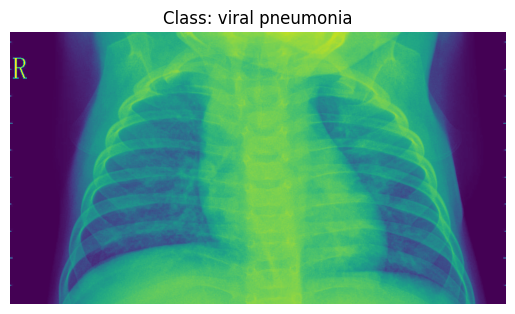

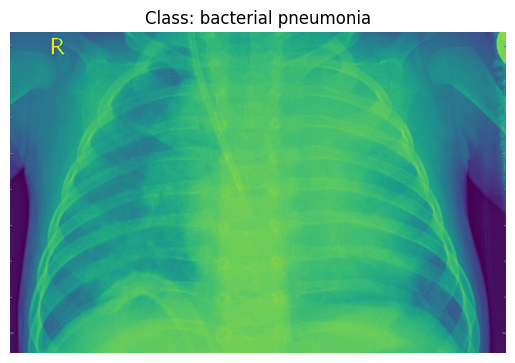

In [ ]:
import random
import matplotlib.pyplot as plt

def load_and_display_random_image(df, path):
  """Loads and displays a random image from the specified dataset."""

  # Choose a random index from the DataFrame
  random_index = random.randint(0, len(df) - 1)

  # Get the filename and class from the DataFrame
  filename = df.iloc[random_index]['Filename']
  class_label = df.iloc[random_index]['Class']

  # Construct the image path
  image_path = os.path.join(path, filename)

  # Load the image using matplotlib
  try:
      img = plt.imread(image_path)
      plt.imshow(img)
      plt.title(f"Class: {class_label}")
      plt.axis('off') # Hide axis ticks and labels
      plt.show()

  except FileNotFoundError:
      print(f"Error: Image file not found at {image_path}")

# Example usage for the training dataset:
load_and_display_random_image(df_train, path_train)

# Example usage for the testing dataset:
load_and_display_random_image(df_test, path_test)

In [ ]:
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.callbacks import EarlyStopping

def create_efficientnet_model(input_shape=(224, 224, 3), num_classes=3):
    # Cargar el modelo EfficientNetB7 preentrenado sin la capa superior
    base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

    # Congelar las capas base
    for layer in base_model.layers:
        layer.trainable = False

    # Añadir nuevas capas superiores
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Crear el modelo
    model = Model(inputs=base_model.input, outputs=x)
    return model, base_model

# Crear el modelo
model_efficientnet, base_model = create_efficientnet_model()

# Compilar el modelo
model_efficientnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Imprimir el resumen del modelo
model_efficientnet.summary()

# Entrenar el modelo (usa EarlyStopping)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history_efficientnet = model_efficientnet.fit(
    data_train_split,
    epochs=20,  # Ajusta según sea necesario
    validation_data=data_val_split,
    callbacks=[early_stopping]
)

# Descongelar las últimas 40 capas después del primer entrenamiento
for layer in base_model.layers[-40:]:  # Descongelar las últimas 20 capas
    layer.trainable = True

# Compilar nuevamente el modelo antes de un segundo entrenamiento
model_efficientnet.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entrenar de nuevo el modelo
history_finetune = model_efficientnet.fit(
    data_train_split,
    epochs=10,  # Ajusta según sea necesario
    validation_data=data_val_split,
    callbacks=[early_stopping]
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_12 (Rescaling)  │ (None, 224, 224, 3)    │              0 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_6           │ (None, 224, 224, 3)    │              7 │ rescaling_12[0][0]     │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_13 (Rescaling)  │ (None, 224, 224, 3)    │              0 │ normalization_6[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_13[0][0]     │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 64)   │          1,728 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 64)   │            256 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 64)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 64)   │            576 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 64)   │            256 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 64)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 64)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 64)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 16)       │          1,040 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 64,105,370 (244.54 MB)

 Trainable params: 7,683 (30.01 KB)

 Non-trainable params: 64,097,687 (244.51 MB)

Epoch 1/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4471 - loss: 1.0919 - val_accuracy: 0.4818 - val_loss: 1.0747
Epoch 2/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 84s 614ms/step - accuracy: 0.4589 - loss: 1.0837 - val_accuracy: 0.4818 - val_loss: 1.0519
Epoch 3/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 83s 605ms/step - accuracy: 0.4653 - loss: 1.0799 - val_accuracy: 0.4818 - val_loss: 1.0542
Epoch 4/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 616ms/step - accuracy: 0.4680 - loss: 1.0778 - val_accuracy: 0.4818 - val_loss: 1.0590
Epoch 5/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 87s 628ms/step - accuracy: 0.4630 - loss: 1.0807 - val_accuracy: 0.4818 - val_loss: 1.0513
Epoch 6/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 619ms/step - accuracy: 0.4774 - loss: 1.0724 - val_accuracy: 0.4818 - val_loss: 1.0600
Epoch 7/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 86s 628ms/step - accuracy: 0.4510 - loss: 1.0886 - val_accuracy: 0.4818 - val_loss: 1.0514
Epoch 8/20
131/131 ━━━━━━━━━━━━━━━━━━━━ 85s 616ms/step - accuracy: 0.4567 - loss: 1.0

In [ ]:
# Save the model to a .h5 file
model_efficientnet.save('efficientnet_model.h5')

print("Model saved as 'efficientnet_model.h5'")

Model saved as 'efficientnet_model.h5'


In [37]:
from google.colab import files

# Download the .h5 file
files.download('efficientnet_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>